In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
from arch import arch_model
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


In [69]:
# First Section
coins = ['BTC-USD', 'ETH-USD', 'USDT-USD', 'XRP-USD', 'BNB-USD']

In [70]:
coin_data = yf.download(coins,
                   start='2024-07-01',
                   end='2025-07-01',
                   interval='1h',
                   group_by='coins',
                   threads=True)

[*********************100%***********************]  5 of 5 completed


In [71]:
results = []

for coin in coins:
    coin_close_data = coin_data[coin]['Close'].dropna()
    adf_result = adfuller(coin_close_data)
    p_value = adf_result[1]
    results.append({'Coin': coin, 'p-value': p_value})

    print(f'***** {coin} Results:')
    print(f'p-value: {p_value}')
    print()

***** BTC-USD Results:
p-value: 0.7974749060453242

***** ETH-USD Results:
p-value: 0.45352269471743767

***** USDT-USD Results:
p-value: 1.2356052494149989e-06

***** XRP-USD Results:
p-value: 0.7184689308990926

***** BNB-USD Results:
p-value: 0.16712649890504017



In [72]:
results_df = pd.DataFrame(results)
sorted_results_df = results_df.sort_values(by='p-value')
print("Sorted by P-Value: \n\n", sorted_results_df)

Sorted by P-Value: 

        Coin   p-value
2  USDT-USD  0.000001
4   BNB-USD  0.167126
1   ETH-USD  0.453523
3   XRP-USD  0.718469
0   BTC-USD  0.797475


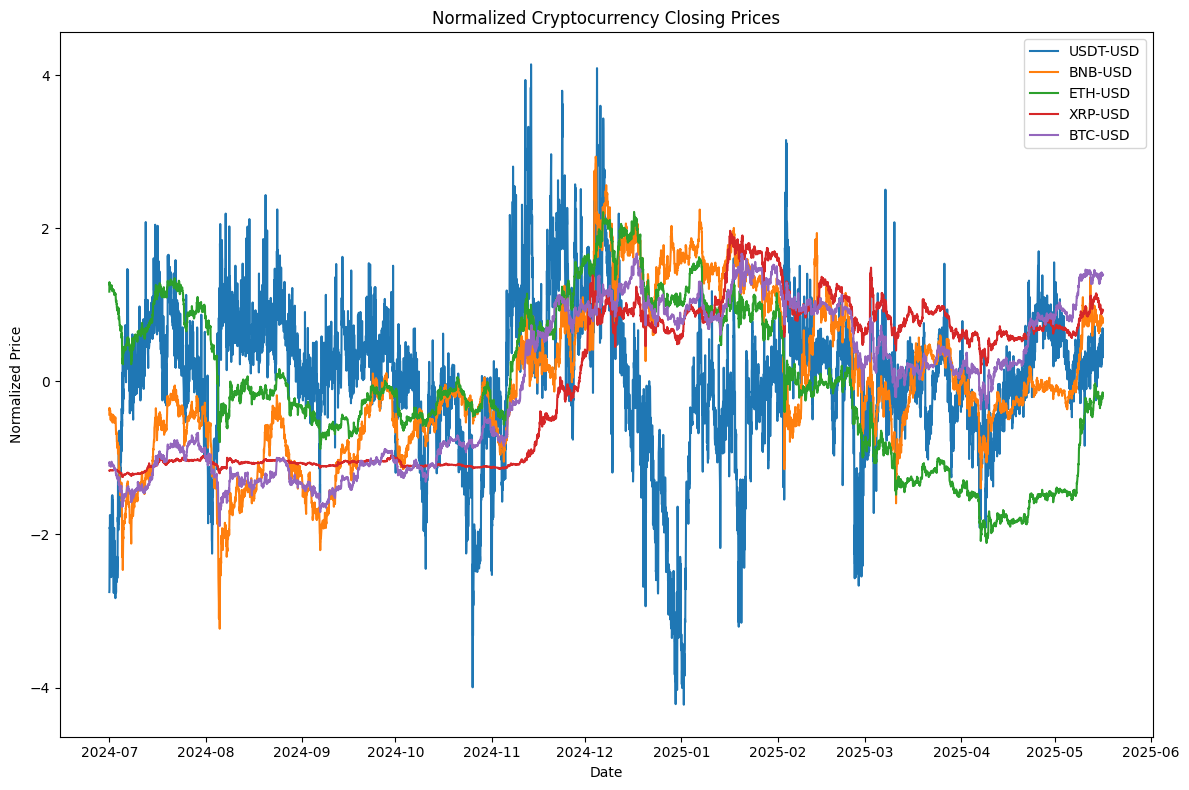

In [73]:
plt.figure(figsize=(12, 8))
for i, row in sorted_results_df.iterrows():
    ticker = row['Coin']
    series = coin_data[ticker]['Close'].dropna()
    normalized_series = (series - series.mean()) / series.std()
    plt.plot(normalized_series, label=ticker)
plt.title('Normalized Cryptocurrency Closing Prices')
plt.xlabel('Date')
plt.ylabel('Normalized Price')
plt.legend()
plt.tight_layout()
plt.show()

In [74]:
btc_close_data = coin_data['BTC-USD']['Close'].dropna()
btc_diff = btc_close_data.diff().dropna()

BTC p-value: 0.0


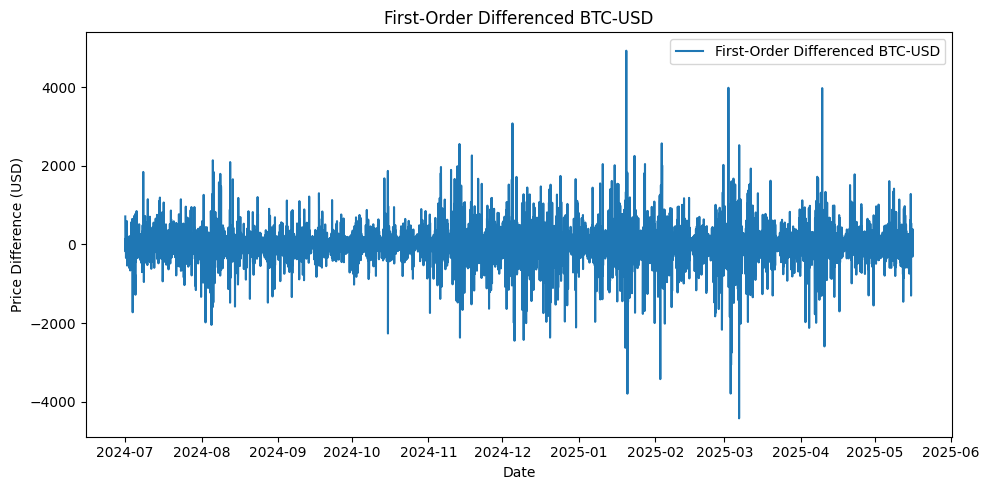

In [75]:
btc_adf_result = adfuller(btc_diff)
print(f'BTC p-value: {btc_adf_result[1]}')

plt.figure(figsize=(10, 5))
plt.plot(btc_diff, label='First-Order Differenced BTC-USD')
plt.title('First-Order Differenced BTC-USD')
plt.xlabel('Date')
plt.ylabel('Price Difference (USD)')
plt.legend()
plt.tight_layout()
plt.show()

In [76]:
# Second Section
coins = ['BTC-USD', 'ETH-USD']

start_main = "2023-07-01"
end_main   = "2024-03-01"
end_val    = "2024-07-01"

train_data = {}
validate_data  = {}

In [96]:
train_data = {}
for coin in coins:
    df_main = yf.download(coin, start=start_main, end=end_main, interval="4h", progress=False)
    df_main.index = pd.to_datetime(df_main.index)
    train_data[coin] = df_main

validate_data = {}
for coin in coins:
    df_val = yf.download(coin, start=start_main, end=end_val, interval="4h", progress=False)
    df_val.index = pd.to_datetime(df_val.index)
    validate_data[coin] = df_val

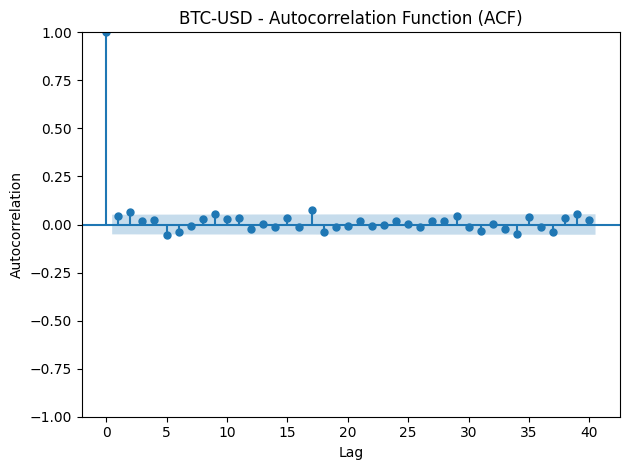

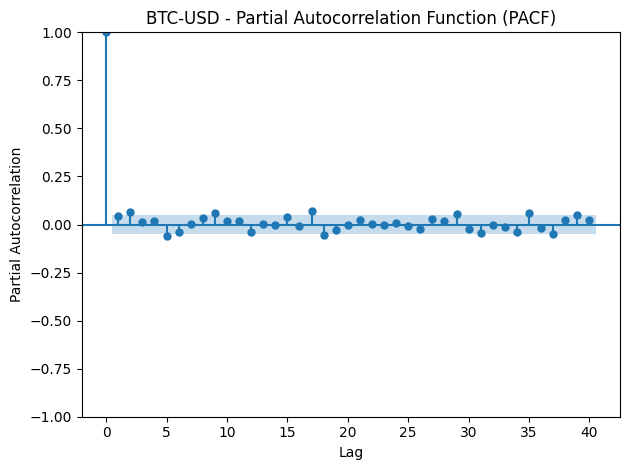

BTC-USD: ARMA(1,1) MSE=0.8822 

BTC-USD: ARCH parameters:
mu         -0.017549
omega       0.563729
alpha[1]    0.163025
Name: params, dtype: float64 

BTC-USD: Predicted volatility for next 546 periods:
[0.76553194 0.81195316 0.81927165 0.82045855 0.82065189]


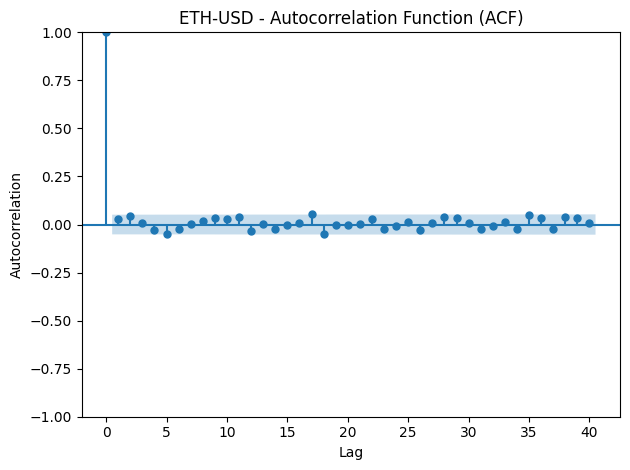

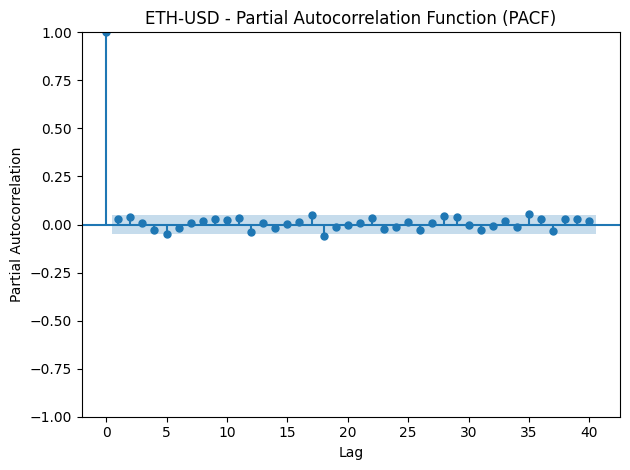

ETH-USD: ARMA(1,1) MSE=1.1927 

ETH-USD: ARCH parameters:
mu         -0.009901
omega       0.646053
alpha[1]    0.215039
Name: params, dtype: float64 

ETH-USD: Predicted volatility for next 546 periods:
[1.10844035 0.9540744  0.91749301 0.90943438 0.90769211]


In [109]:
results = {}

for coin in coins:
    # Extract and process the training time series
    ts = train_data[coin]['Close']
    ts = ts.pct_change().dropna() * 100  # Convert to percentage returns

    # Perform ADF test for stationarity
    adf_p = adfuller(ts)[1]
    if adf_p > 0.05:
        ts = ts.diff().dropna()

    ts = ts.asfreq('4h')  # Ensure 4-hour frequency

    # Plot ACF and PACF
    plot_acf(ts, lags=40)
    plt.title(f"{coin} - Autocorrelation Function (ACF)")
    plt.xlabel("Lag")
    plt.ylabel("Autocorrelation")
    plt.tight_layout()
    plt.show()

    plot_pacf(ts, lags=40, method='ywm')
    plt.title(f"{coin} - Partial Autocorrelation Function (PACF)")
    plt.xlabel("Lag")
    plt.ylabel("Partial Autocorrelation")
    plt.tight_layout()
    plt.show()

    # Determine ARMA order using ACF and PACF
    N = len(ts)
    bound = 2 / np.sqrt(N)
    acf_vals = acf(ts, nlags=40, fft=False)
    pacf_vals = pacf(ts, nlags=40, method='ywm')
    p = next((i for i, val in enumerate(pacf_vals) if abs(val) < bound), 1)
    q = next((i for i, val in enumerate(acf_vals) if abs(val) < bound), 1)

    # Fit ARMA model
    arma_model = ARIMA(ts, order=(p, 0, q), enforce_stationarity=False, enforce_invertibility=False)
    arma_result = arma_model.fit()

    # Forecast and compute prediction errors on the validation set
    val_ts = validate_data[coin]['Close'].pct_change().dropna() * 100
    val_ts = val_ts.asfreq('4h')
    forecast = arma_result.forecast(steps=len(val_ts))
    mse = mean_squared_error(val_ts[:len(forecast)], forecast)

    # Extract residuals for ARCH modeling
    residuals = arma_result.resid

    # Fit ARCH model to residuals with automatic rescaling
    am = arch_model(residuals, vol='ARCH', p=1, rescale=True)
    arch_result = am.fit(disp='off')

    # Forecast volatility for the test period
    test_period = 546  # Number of 4-hour periods from Dec 1, 2023, to Mar 1, 2024
    forecast_volatility = arch_result.forecast(horizon=test_period)
    scale = arch_result.scale
    predicted_variance = forecast_volatility.variance.values[-1, :] / (scale ** 2)
    predicted_volatility = np.sqrt(predicted_variance)

    # Store results
    results[coin] = {
        'ARMA_order': (p, q),
        'ARMA_mse': mse,
        'ARCH_params': arch_result.params,
        'Predicted_volatility': predicted_volatility
    }

    print(f"{coin}: ARMA({p},{q}) MSE={mse:.4f} \n")
    print(f"{coin}: ARCH parameters:\n{arch_result.params} \n")
    print(f"{coin}: Predicted volatility for next {test_period} periods:\n{predicted_volatility[:5]}")

In [113]:
garch_model = arch_model(residuals, vol='Garch', p=1, q=1, mean='Zero')
garch_result = garch_model.fit(disp='off')

# Forecast volatility for the test period
forecast_horizon = 546  # Adjust as needed
garch_forecast = garch_result.forecast(horizon=forecast_horizon)
predicted_volatility = garch_forecast.variance.values[-1, :]

# Output results
print("GARCH(1,1) Model Parameters:")
print(garch_result.params)
print(f"\nPredicted Volatility for Next {forecast_horizon} Periods:")
print(predicted_volatility[:5])

GARCH(1,1) Model Parameters:
omega       0.070661
alpha[1]    0.137461
beta[1]     0.786611
Name: params, dtype: float64

Predicted Volatility for Next 546 Periods:
[1.91730201 1.84238596 1.77315816 1.70918671 1.65007249]


In [114]:
figarch_model = arch_model(residuals, vol='Figarch', p=1, q=1, mean='Zero')
figarch_result = figarch_model.fit(disp='off')

# Forecast volatility for the test period
forecast_horizon = 546  # Adjust as needed
figarch_forecast = figarch_result.forecast(horizon=forecast_horizon)
predicted_volatility = figarch_forecast.variance.values[-1, :]

# Output results
print("FIGARCH(1,1) Model Parameters:")
print(figarch_result.params)
print(f"\nPredicted Volatility for Next {forecast_horizon} Periods:")
print(predicted_volatility[:5])

FIGARCH(1,1) Model Parameters:
omega    0.113495
phi      0.215971
d        0.266246
beta     0.352390
Name: params, dtype: float64

Predicted Volatility for Next 546 Periods:
[1.76476843 1.67270428 1.60447732 1.54727437 1.50066419]


Strongest Granger causality: TRX-USD → XRP-USD, p-value=0.0000


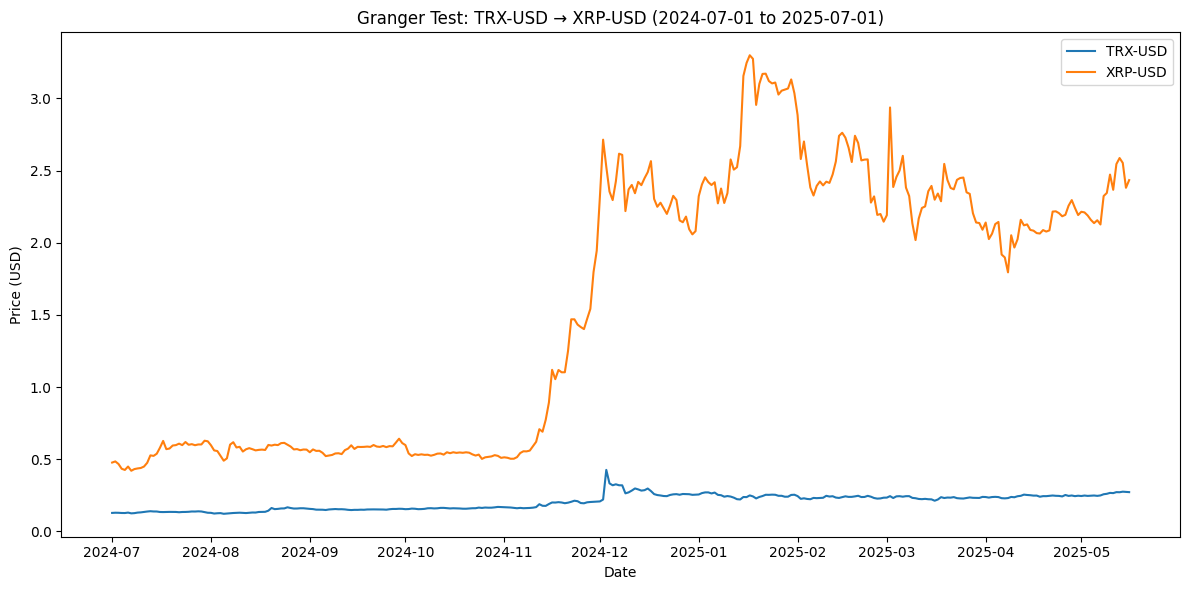

In [116]:
# Section 4
import warnings
from statsmodels.tsa.stattools import grangercausalitytests

warnings.filterwarnings("ignore", category=FutureWarning)

# Top-10 crypto tickers on Yahoo Finance
top10 = [
    'BTC-USD', 'ETH-USD', 'USDT-USD', 'BNB-USD', 'XRP-USD',
    'DOGE-USD', 'ADA-USD', 'SOL-USD', 'DOT-USD', 'TRX-USD'
]

# Download daily closing prices
data = yf.download(top10, start='2024-07-01', end='2025-07-01', progress=False)['Close']

# Drop missing values
data = data.dropna()

# Compute Granger causality p-values for each pair (maxlag=5)
results = {}
for x in top10:
    for y in top10:
        if x != y:
            test_res = grangercausalitytests(data[[x, y]], maxlag=5, verbose=False)
            pvals = [res[0]['ssr_ftest'][1] for res in test_res.values()]
            results[(x, y)] = min(pvals)

# Identify strongest causality pair
best_pair = min(results, key=results.get)
lead, follow = best_pair
print(f"Strongest Granger causality: {lead} → {follow}, p-value={results[best_pair]:.4f}")

# Plot the price series
plt.figure(figsize=(12, 6))
plt.plot(data[lead], label=lead)
plt.plot(data[follow], label=follow)
plt.title(f"Granger Test: {lead} → {follow} (2024-07-01 to 2025-07-01)")
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.tight_layout()
plt.show()
